In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

In [31]:
path = './../growth-lab-diversity/data/sources/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

path = './../growth-lab-diversity/data/sources/BLS/'

uc = ['area_fips', 'industry_code', 'agglvl_code', 'year', 'annual_avg_estabs', 'annual_avg_emplvl', 'total_annual_wages']

df_list = []
for y in np.arange(2006, 2016):
    df_y = pd.read_csv(path+str(y)+'_annual_singlefile.zip', usecols = uc, low_memory=False)
    df_list += [df_y]
    
df = pd.concat(df_list)

In [32]:
# Get robustness from using 10 years

variable = 'annual_avg_estabs'
#correct possible mistakes, index should be like c-p-y
cpy_ix = df.loc[df.agglvl_code == 76].groupby(['year', 'area_fips', 'industry_code'])[[variable]].sum()
year_avg = cpy_ix.reset_index().drop('year', axis = 1).groupby(['area_fips', 'industry_code'])[[variable]].mean()
# summary_var = df_2015.drop('year', axis = 1).loc[df_2015.agglvl_code == 76].groupby(['area_fips', 'industry_code'])[[variable]].sum()
X = year_avg.unstack()[variable]

### TRANSPOSE FOR HAVING AREAS AS NODES
X = X.T

In [33]:
# # Add population

# county_pop = pd.read_csv('./data/co-est2017-alldata.csv')
# county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)

# county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

# X = pd.concat([county_pop, X], axis = 1)

In [34]:
cor_mat = log10(X).corr(min_periods = 20)
cov_mat = log10(X).cov(min_periods = 20)

./../Hidalgo_Haussmann/HH_tools.py:58: RuntimeWarning: divide by zero encountered in log10
  return np.log10(df).replace(-np.inf, np.nan)


In [35]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

def stand(Z):
    Z = Z.fillna(0)
    std = Z.std()
    return Z.T.div(std).T.div(std)

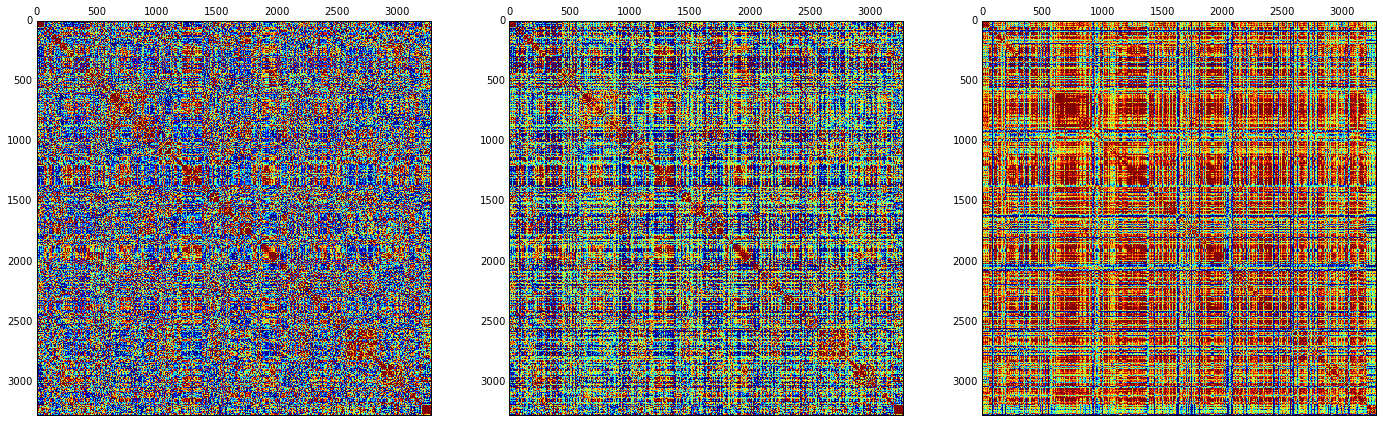

In [36]:
fig, axs = plt.subplots(1, 3, figsize = (24, 8))

axs[0].matshow(demean(stand(demean(cor_mat))), vmin = -10, vmax = 10)
axs[1].matshow(demean(cor_mat), vmin = -.1, vmax = .1)
axs[2].matshow(cor_mat.fillna(0), vmin = .2, vmax = .7)

# plt.hist(stand(demean(cor_mat)).std(), 30)
# plt.show()

In [37]:
# Try spectral clustering. Works when matrix is demeaned
from sklearn.cluster import SpectralClustering
X_ = demean(cor_mat).values
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0).fit(X_)

pd.options.display.max_rows = 500
clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
# clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])
clust_result = pd.concat([clust_result, area_titles.set_index('area_fips')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'area_title'])
clust_result.index.name = 'area_fips'

/home/miglesia/anaconda2/lib/python2.7/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [38]:
edges = pd.DataFrame(demean(cor_mat).stack(), columns = ['dem_corr'])
# > demean(cor_mat).values, 90
# edges.loc[]
edges_s = edges.loc[edges.dem_corr > edges.dem_corr.quantile(.99)]

#
edges_s.index.names = ['area_fips_x', 'area_fips_y']
edges_s = edges_s.reset_index().merge(
    area_titles, left_on = 'area_fips_x', right_on = 'area_fips').merge(
    area_titles, left_on = 'area_fips_y', right_on = 'area_fips').T.drop_duplicates().T
edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)

# edges_s.index.names = ['industry_code_x', 'industry_code_y']
# edges_s = edges_s.reset_index().merge(
#     industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
#     industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
# edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)



In [39]:
### Add node colors and size

import matplotlib.colors as mcolors

# nodes = industry_titles

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)
nodes.index.name = 'area_fips'

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))

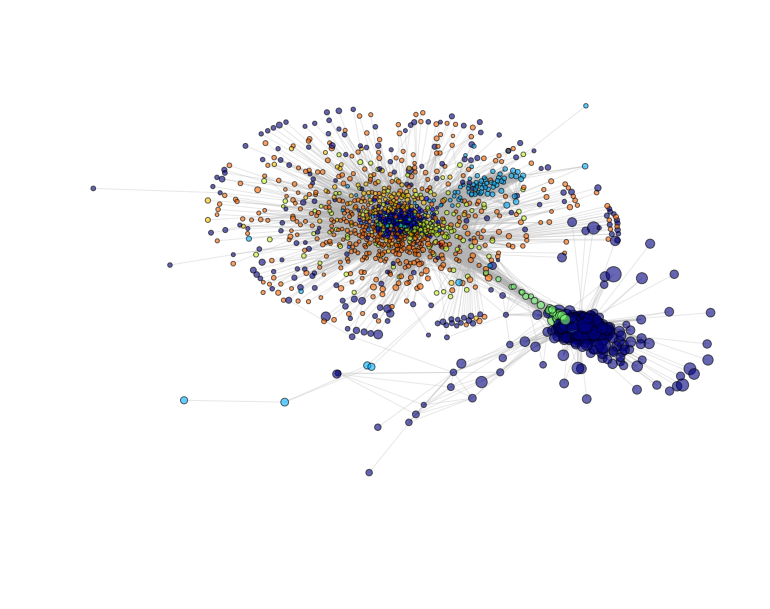

In [40]:
# max_d = 200

#         ### Max degree = max_d. Parameter used to trim the network.
# df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
# df2 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
# edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

###

# Hard threshold and max degree backboning
weight_column = 'dem_corr' #'weight_'+geo
# G = nx.from_pandas_edgelist(edges_s, 'industry_code_x', 'industry_code_y', weight_column) #edges_max_d
G = nx.from_pandas_edgelist(edges_s, 'area_fips_x', 'area_fips_y', weight_column) #edges_max_d


plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]
pos = nx.spring_layout(G, k=.1)

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
# plt.title('max_d = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()

### Clusters on map

In [11]:
# nodes.to_csv('./data/US_area_nodes.csv')
# nodes = pd.read_csv('./data/US_area_nodes.csv', index_col='area_fips')

In [41]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties = counties.set_index('area_fips')[['geometry']]

gdf = gpd.GeoDataFrame(pd.concat([nodes, counties], axis = 1, sort = True).dropna())

(15, 50)

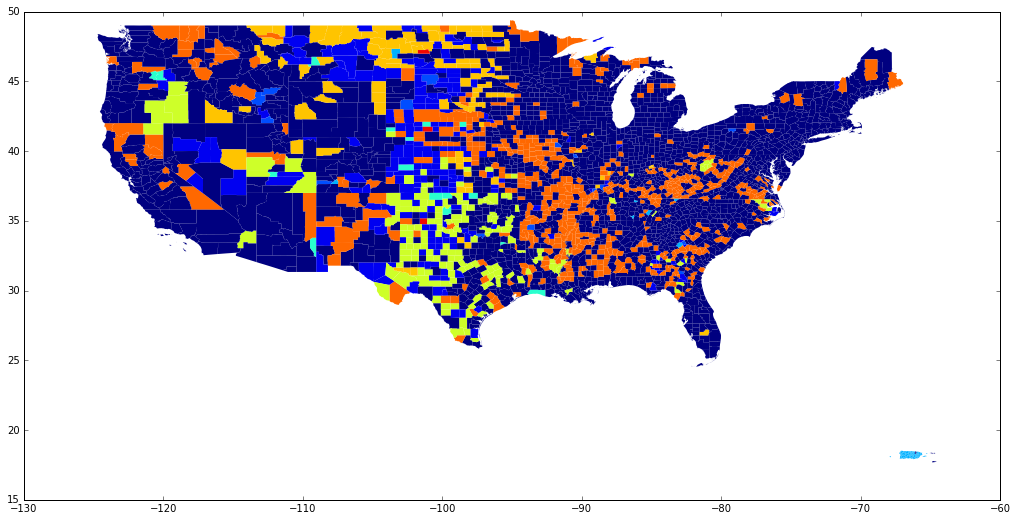

In [44]:
ax = gdf.plot(column='cluster', cmap=plt.cm.jet, vmin = 0, vmax = 10, linewidth = 0, figsize = (17.5, 12))
ax.set_xlim(-130, -60)
ax.set_ylim(15, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)

### Draw in d3plus

In [77]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)

In [78]:
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'area_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
# nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]


In [80]:
import sys
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
import pandas as pd
from HH_tools import robust_proximity, year_to_tp, RCA

In [86]:
edges_max_d = edges_s
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.area_fips_x, edges_max_d.area_fips_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.area_fips_y, edges_max_d.area_fips_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['area_fips_y'].astype(str).str.zfill(4)
links['source'] = links['area_fips_x'].astype(str).str.zfill(4)

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
# network

In [57]:
edges_max_d_triangles.to_csv('edges_max_d_triangles_areas.csv', index = False)

In [58]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

### Color by Population Density

In [26]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [27]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [28]:
pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'node_name'})
nodes_ = nodes_.merge(pop_dens_index, on = 'node_name', how = 'left')
nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

from numpy import nan
rainbow_colors = {0:'#9400D3', #Violet
1:'#4B0082', #Indigo
2:'#0000FF', #Blue
3:'#00FF00', #Green
nan:'#D3D3D3',  #'#D3D3D3', #Gray
4:'#FFFF00', #Yellow
5:'#FF7F00', #Orange
6:'#FF0000'} #Red

nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [29]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

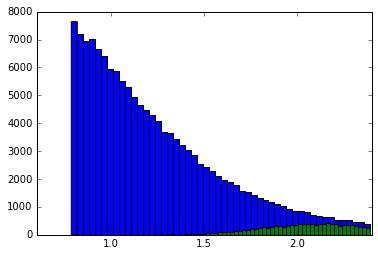

In [30]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()